In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import tensorflow as tf
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
class TrainingConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME = "mechparts"
    BACKBONE = "resnet50"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1    
    STEPS_PER_EPOCH = 10
    DETECTION_MIN_CONFIDENCE = 0.9
    VALIDATION_STEPS = 1
    IMAGE_MAX_DIM = 64
    
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    
    

config = TrainingConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class DetailsDataset(utils.Dataset):
    def load_data_image(self, dataset_dir, subset):
        # Add classes
        self.add_class("detail", 1, "detail")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(dataset_dir)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys        
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "detail",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)


    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
    #         image_info = self.image_info[image_id]
    #         if image_info["source"] != "detail":
    #             return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)        

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "detail":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
        
        
        
    

In [9]:
# path_to_data = "/mnt/49de8826-e139-4a7d-8735-eec0ae9571c9/Projects/Mech_parts_detecting/input/buckets/ready/"
# path_to_data = "/home/leo/Документы/machpart/ready"
path_to_data = '../images/ready/'

# Training dataset.
dataset_train = DetailsDataset()
dataset_train.load_data_image(path_to_data, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = DetailsDataset()
dataset_val.load_data_image(path_to_data,"val")
dataset_val.prepare()



../images/ready/train
../images/ready/val


In [6]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:

# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /media/leo/Reonid/application/MechPart/MechPart_detector/Manual/Development/Mask_RCNN_MPD/logs/mechparts20190120T1050/mask_rcnn_mechparts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2   

/home/leo/anaconda3/envs/mechpart/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/leo/anaconda3/envs/mechpart/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
10/10 [==============================] - 82s 8s/step - loss: 4.8305 - rpn_class_loss: 0.7327 - rpn_bbox_loss: 3.7882 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.0732 - val_loss: 5.1535 - val_rpn_class_loss: 0.4413 - val_rpn_bbox_loss: 2.6160 - val_mrcnn_class_loss: 0.0193 - val_mrcnn_bbox_loss: 1.3609 - val_mrcnn_mask_loss: 0.7160


## Visualization


In [34]:
class InferenceConfig(Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    NAME = "mech"
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 1  # Background + balloon
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.0
    BACKBONE = "resnet50"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [35]:
LATEST_MODEL_PATH = "/mnt/49de8826-e139-4a7d-8735-eec0ae9571c9/Projects/Mech_parts_detecting/Models/Mask_RCNN_MPD/logs/mechparts20181106T1339/mask_rcnn_mechparts_0010.h5"
with tf.device("/gpu:0"):
    # Create model object in inference mode.
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(LATEST_MODEL_PATH, by_name=True)

Re-starting from epoch 10


Processing 1 images
image                    shape: (3024, 4032, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


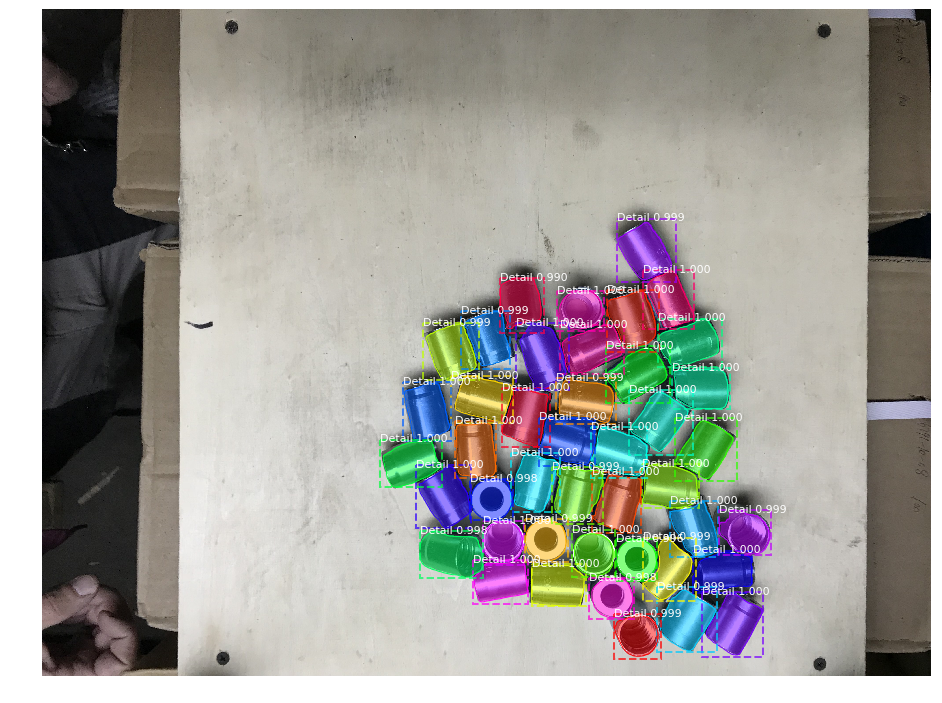

In [42]:
class_names=['bg', "Detail"]

path_to_test = "/mnt/49de8826-e139-4a7d-8735-eec0ae9571c9/Projects/Mech_parts_detecting/input/buckets/blank/val"


# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
file_name = path_to_test + "/184.jpg"
file_name = path_to_test + "/188.jpg"
# file_name = path_to_test + "/192.jpg"
# file_name = path_to_test + "/191.jpg"

# file_name = path_to_test + "/2.jpg"

# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = skimage.io.imread(file_name)


# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]


In [ ]:
len(results[0]["class_ids"])

In [ ]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9111685320781054014
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10258323866
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4814939720836174625
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [2]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [2]:
help('modules')



Please wait a moment while I gather a list of all available modules...



/home/leo/anaconda3/lib/python3.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/home/leo/anaconda3/lib/python3.7/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


/home/leo/anaconda3/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
DEBUG:pip._internal.vcs:Registered VCS backend: git
DEBUG:pip._internal.vcs:Registered VCS backend: hg
DEBUG:pip._internal.vcs:Registered VCS backend: svn
DEBUG:pip._internal.vcs:Registered VCS backend: bzr


/home/leo/anaconda3/lib/python3.7/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "
/home/leo/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/home/leo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/leo/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  

Crypto              brain_mechanize     json                rope
Cython              brain_multiprocessing jsonschema          ruamel_yaml
IPython             brain_namedtuple_enum jupyter             runpy
OpenSSL             brain_nose          jupyter_client      sched
PIL                 brain_numpy         jupyter_console     scipy
PyQt5               brain_pkg_resources jupyter_core        scripts
__future__          brain_pytest        jupyterlab          seaborn
_abc                brain_qt            jupyterlab_launcher secrets
_ast                brain_random        keyring             secretstorage
_asyncio            brain_re            keyword             select
_bisect             brain_six           kiwisolver          selectors
_blake2             brain_ssl           lazy_object_proxy   send2trash
_bootlocale         brain_subprocess    lib2to3             service_identity
_bz2                brain_threading     linecache           setuptools
_cffi_backend       brain_t

/home/leo/anaconda3/lib/python3.7/pkgutil.py:107: VisibleDeprecationWarning: zmq.eventloop.minitornado is deprecated in pyzmq 14.0 and will be removed.
    Install tornado itself to use zmq with the tornado IOLoop.
    
  yield from walk_packages(path, info.name+'.', onerror)
